In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
## Reading input data 
isis = pd.read_csv('tweets.csv')
print(isis.head())

            name  ...                                             tweets
0  GunsandCoffee  ...  ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1  GunsandCoffee  ...  ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2  GunsandCoffee  ...  ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3  GunsandCoffee  ...  ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4  GunsandCoffee  ...  ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...

[5 rows x 8 columns]


In [3]:
## understanding input data 
print(isis.describe())
print()
print(isis.value_counts())

          followers  numberstatuses
count  17410.000000    17410.000000
mean    3975.076680     4760.787651
std     8674.378495     7015.967275
min       16.000000        1.000000
25%      266.000000      207.000000
50%      928.000000      908.000000
75%     1791.000000     6865.000000
max    34692.000000    33091.000000

name              username        description                                                                                                                                                     location                    followers  numberstatuses  time             tweets                                                                                                                                          
كتكات كوكونت      Uncle_SamCoco   Here to defend the  American freedom and also the freedom of coconut . Cat Lover or Hater. Kebab Fan . We're all living in America, America ist wunderbar #USA  Texas, USA                  1809       6743            5/6/2016 9:41  

In [4]:
## correlation between the two numeric variables 
corr = isis.corr()
corr.style.background_gradient(cmap='coolwarm')

,followers,numberstatuses
followers,1.000000,0.578975
numberstatuses,0.578975,1.000000


Time Series Analysis

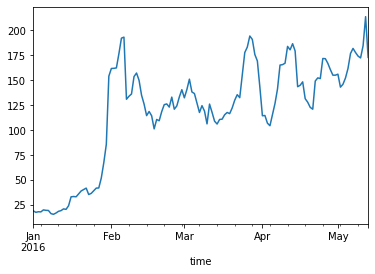

In [5]:
## analysing the trend of tweets over time 
from scipy import interpolate
import seaborn as sns
isis.time = pd.to_datetime(isis.time)
perhr = isis.set_index(isis['time']).resample('D').count()
perhr.rolling(7).mean().tweets['2016-01-01':].plot()

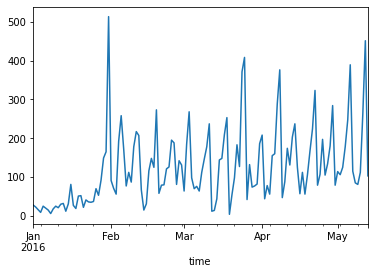

In [6]:
## number of tweets per day
perhr['2016-01-01':].numberstatuses.plot()

Text(0.5, 1.0, 'Tweets pattern in 2016')

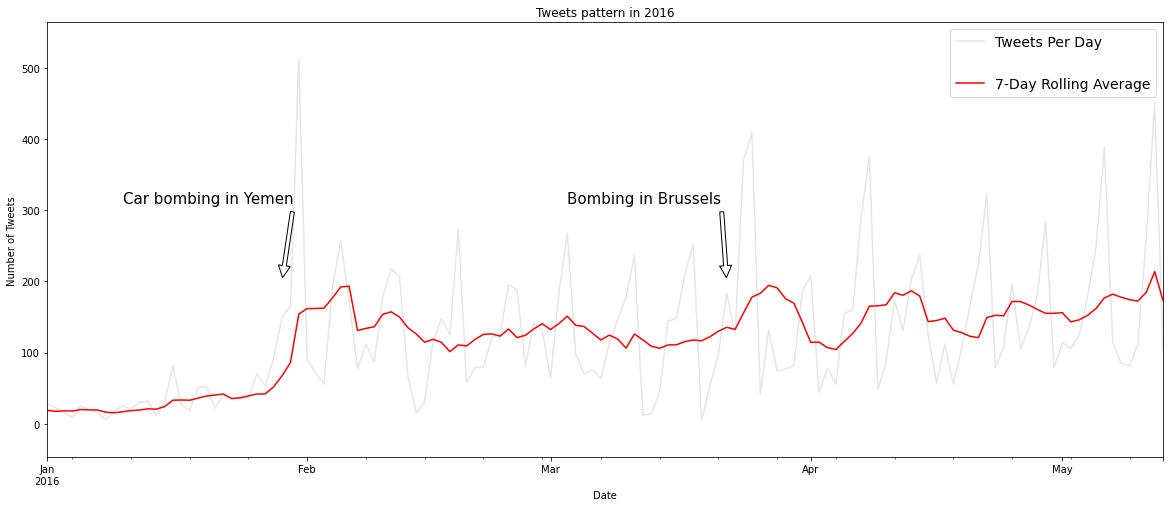

In [7]:
## checking the tweets trend during Brussels and Yemen Attacks
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20,8))
perhr['2016-01-01':].numberstatuses.interpolate(method='linear').plot(ax = ax, color="black", fontsize=10, alpha=0.1)
perhr.rolling(7).mean().tweets['2016-01-01':].plot(color ='r')
yemen = '2016-01-29'
brussels = '2016-03-22'
ax.annotate('Bombing in Brussels',xy=(brussels, 200),xytext=('2016-03-03', 310),
            arrowprops=dict(facecolor='white', shrink=0.05), size=15)
ax.annotate('Car bombing in Yemen',xy=(yemen, 200),xytext=('2016-01-10', 310),
            arrowprops=dict(facecolor='white', shrink=0.05),size=15)
ax.margins(None,0.1)
ax.legend(['Tweets Per Day','7-Day Rolling Average'], loc = 'upper right',
           numpoints = 1, labelspacing = 2.0, fontsize = 14)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweets pattern in 2016')

Users with maximum number of tweets

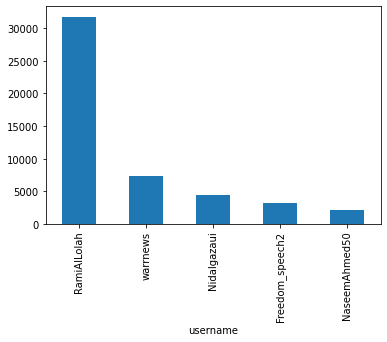

In [8]:
## finding users with maximum followers
isis.groupby(['username']).mean()['followers'].sort_values(ascending=False).head().plot(kind = 'bar')

Data Pre-processing 

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

tweet_only = isis['tweets']
tweet_only = pd.DataFrame(tweet_only)
tweet_only.columns = ['tweets']
tweet_only['tweets'] = tweet_only.tweets.astype(str)
tweet_only['tweets'] = tweet_only['tweets'].str.lower()
tweet_only['tweets'] = tweet_only['tweets'].str.replace('[^\w\s]','')
tweet_only['tweets'] = tweet_only['tweets'].str.replace(r"[\"\',]", '')
tweet_only['tweets'] = tweet_only['tweets'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
tweet_only['tweet_without_stopwords'] = tweet_only['tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
tweet_only['tweet_without_stopwords'] = tweet_only['tweet_without_stopwords'].str.lstrip('english translation')
tweet_only.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweets,tweet_without_stopwords
0,english translation message to the truthful in...,message truthful syria sheikh abu muhammed al ...
1,english translation sheikh fatih al jawlani fo...,kh fatih al jawlani people integrity sacrifice...
2,english translation first audio meeting with s...,first audio meeting sheikh fatih al jawlani ha...
3,english translation sheikh nasir al wuhayshi h...,kh nasir al wuhayshi ha leader aqap promise vi...
4,english translation aqap response to sheikh ba...,qap response sheikh baghdadis statement althou...


TF-IDF (Finding important words)

In [10]:
# Starting with the CountVectorizer/TfidfTransformer approach...
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

cvec = CountVectorizer(stop_words='english', min_df=1, max_df=.5, ngram_range=(1,2))
cvec

from itertools import islice
cvec.fit(isis.tweets)
list(islice(cvec.vocabulary_.items(), 20))

cvec = CountVectorizer(stop_words='english', min_df=.0025, max_df=.1, ngram_range=(1,2))
cvec.fit(isis.tweets)
len(cvec.vocabulary_)

cvec_counts = cvec.transform(isis.tweets)
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english')
tvec_weights = tvec.fit_transform(isis.tweets)
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,term,weight
39,al,0.026532
503,syria,0.025684
51,amp,0.023104
282,killed,0.019168
42,allah,0.016802
64,army,0.014819
255,iraq,0.014673
68,assad,0.014415
491,state,0.013859
258,islamic,0.013547


Word Cloud

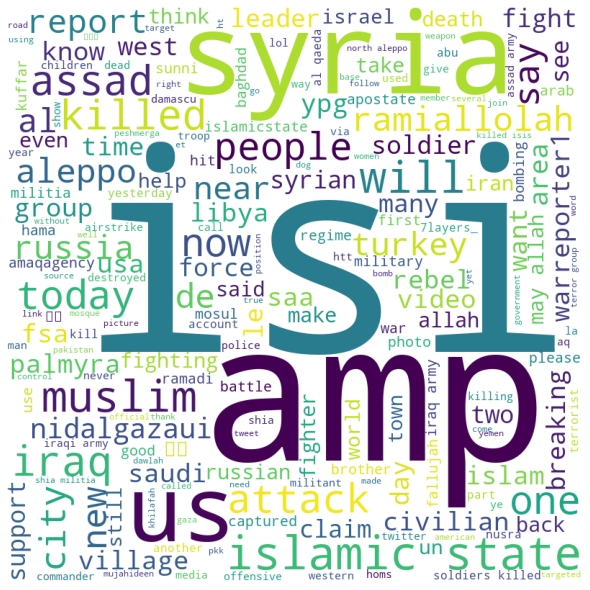

In [11]:
## word cloud

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 
comment_words = ''
stopwords = set(STOPWORDS)
stopwords |= {"https","co",'rt'}
 
for val in isis.tweets:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Tweets Classification

In [12]:
## checking for positive and negative tweets
positive_words = pd.read_excel('positive_words.xlsx')
positive_words = pd.DataFrame(positive_words)
positive_words.columns = ['words']
positive_words['words'] = positive_words['words'].astype(str)
positive_list = positive_words["words"].tolist()
pattern_positive = '|'.join(positive_list) 

negative_words = pd.read_excel('negative_words.xlsx')
negative_words = pd.DataFrame(negative_words)
negative_words.columns = ['words']
negative_words['words'] = negative_words['words'].astype(str)
negative_list = negative_words["words"].tolist()
pattern_negative = '|'.join(negative_list)

isis_test = tweet_only
isis_test['pos_col'] = isis_test.tweet_without_stopwords.str.contains(pattern_positive)
isis_test['neg_col'] = isis_test.tweet_without_stopwords.str.contains(pattern_negative)

Network Analysis

Most mentioned user is RamiAlLolah with 565 times mentioned by the other users.
Most active user is Uncle_SamCoco with 1578 times mentioning other users.
Most mentioned user is RamiAlLolah with 565 times mentioned by the other users.
Most active user is mobi_ayubi with 1578 times mentioning other users.
The 10 most frequent tagged user pairs are 


(-1.2070521593819699,
 1.2097198884480604,
 -1.2091927295532137,
 1.209192751038609)

<Figure size 432x288 with 0 Axes>

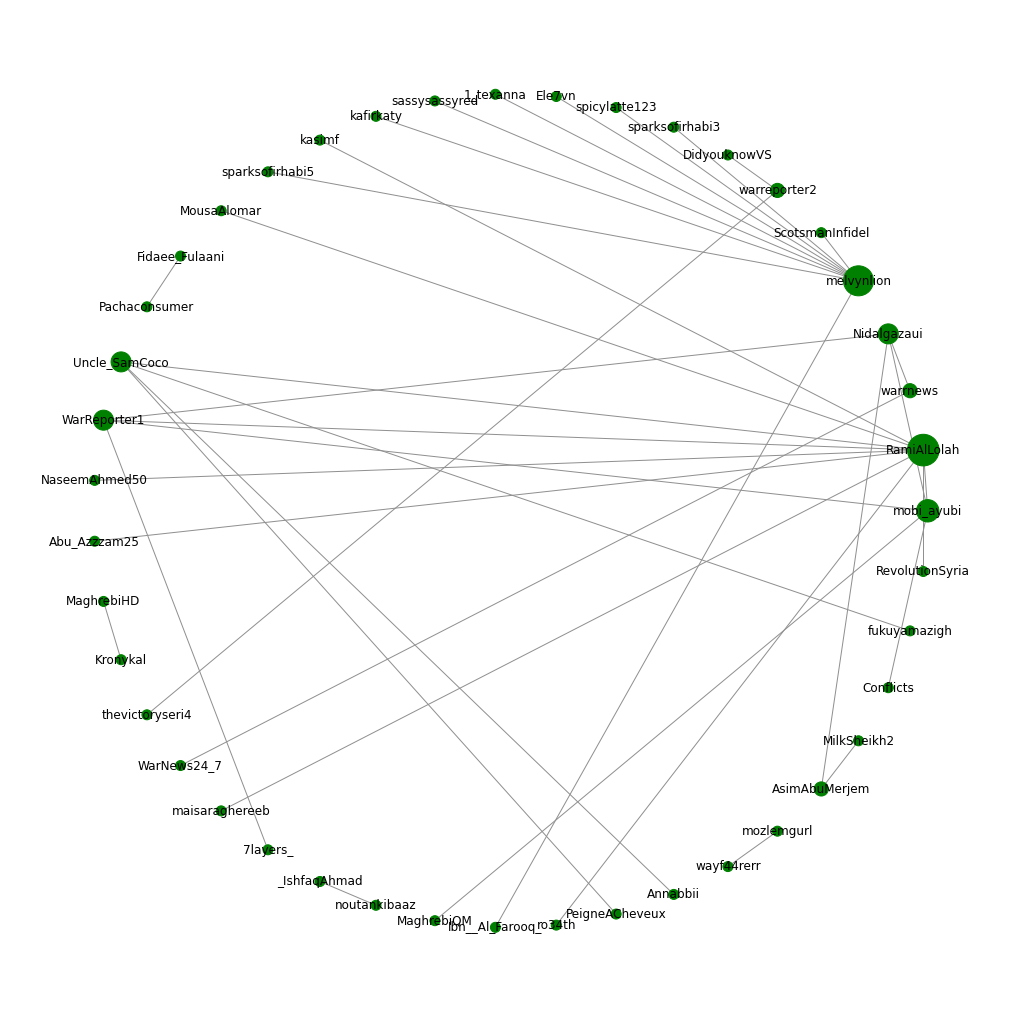

In [13]:
import sklearn
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import re

df = pd.read_csv('tweets.csv')

index = []
for i in range(len(df['tweets'])):
    if '@' in df['tweets'][i]:
        index.append(i)
        
With_mention = df.iloc[index,:].reset_index(drop=True)
With_mention['Tagged_User'] = With_mention['tweets'].apply(lambda x: re.findall(r'@([A-Za-z0-9_]+)',str(x)))
User = With_mention['username'].unique()
With_mention['Tagged_User_Co'] = With_mention['Tagged_User'].apply(lambda x: list(set(x).intersection(User)) )
With_mention['Co_length'] = With_mention['Tagged_User_Co'].apply(lambda x: len(x))
With_mention_2 = With_mention[With_mention['Co_length']>0].reset_index(drop=True)

for i in range(len(With_mention['tweets'])):
    frame = With_mention.iloc[i,:]
    for j in range(len(frame['Tagged_User'])):
        tmp = pd.DataFrame({'User':[frame['username']],'Mentions':[frame['Tagged_User'][j]],'Time': [frame['time']],'User_numberstatuses':[frame['numberstatuses']],'User_followers':[frame['followers']],'Weight': [1]})
        if i==0 and j==0:
            Mention_net = tmp
        else:
            Mention_net = Mention_net.append(tmp, ignore_index=True)

for i in range(len(With_mention_2['tweets'])):
    frame = With_mention_2.iloc[i,:]
    for j in range(len(frame['Tagged_User_Co'])):
        Mentioned_follower = list(df[df['username']==frame['Tagged_User_Co'][j]]['followers'])[0]
        Mehtioned_statuses = list(df[df['username']==frame['Tagged_User_Co'][j]]['numberstatuses'])[0] 
        tmp = pd.DataFrame({'Mentioned_statuses':[Mehtioned_statuses],'Mentioned_followers':[Mentioned_follower],'User':[frame['username']],'Mentions':[frame['Tagged_User_Co'][j]],'Time': [frame['time']],'User_numberstatuses':[frame['numberstatuses']],'User_followers':[frame['followers']],'Weight': [1]})
        if i==0 and j==0:
            Mention_net_2 = tmp
        else:
            Mention_net_2 = Mention_net_2.append(tmp, ignore_index=True)

Mention_net = Mention_net[Mention_net['User']!=Mention_net['Mentions']]
Mention_net_2 = Mention_net_2[Mention_net_2['User']!=Mention_net_2['Mentions']]

Mention_net = Mention_net.reset_index(drop=True)
Mention_net_2 = Mention_net_2.reset_index(drop=True)

In_degree = Mention_net.groupby(by=['Mentions'],as_index=False)['Weight'].sum()
Out_degree= Mention_net.groupby(by=['User'],as_index=False)['Weight'].sum()

In_degree = pd.DataFrame(In_degree).sort_values(by='Weight',ascending=False).reset_index(drop=True)
Out_degree = pd.DataFrame(Out_degree).sort_values(by='Weight',ascending=False).reset_index(drop=True)

print( 'Most mentioned user is '+str(In_degree['Mentions'][0])+' with ' + str(In_degree['Weight'][0])+' times mentioned by the other users.')
print( 'Most active user is '+str(Out_degree['User'][0])+' with ' + str(Out_degree['Weight'][0])+' times mentioning other users.')

In_degree_2 = Mention_net_2.groupby(by=['Mentions'],as_index=False)['Weight'].sum()
Out_degree_2= Mention_net_2.groupby(by=['User'],as_index=False)['Weight'].sum()

In_degree_2 = pd.DataFrame(In_degree_2).sort_values(by='Weight',ascending=False).reset_index(drop=True)
Out_degree_2 = pd.DataFrame(Out_degree_2).sort_values(by='Weight',ascending=False).reset_index(drop=True)

print( 'Most mentioned user is '+str(In_degree_2['Mentions'][0])+' with ' + str(In_degree['Weight'][0])+' times mentioned by the other users.')
print( 'Most active user is '+str(Out_degree_2['User'][0])+' with ' + str(Out_degree['Weight'][0])+' times mentioning other users.')

network1 = Mention_net.iloc[:,[0,1,2,5]]

network1.head(5)

network1 = network1.groupby(by=['Mentions','User'],as_index='False')['Weight'].sum().reset_index(name='Weight')
network1= pd.DataFrame(network1).sort_values(by='Weight',ascending=False).reset_index(drop=True)
network1 = network1[network1['Weight']>20]
import networkx as nx

print('The 10 most frequent tagged user pairs are ')
network1.iloc[0:9,:]

G = nx.Graph()
for i in range(len(network1['User'])):
    G.add_edge(network1['User'][i],network1['Mentions'][i],weight=network1['Weight'][i])

plt.figure(1)
plt.figure(figsize=(14,14))
d = dict(G.degree)
nx.draw_circular(G,node_color='g', edge_color='#909090', node_size=[v*100 for v in d.values()],with_labels=True)
plt.axis('equal')

(-1.2099999746680261,
 1.2099999975928892,
 -1.2011777142776907,
 1.2011777038088725)

<Figure size 432x288 with 0 Axes>

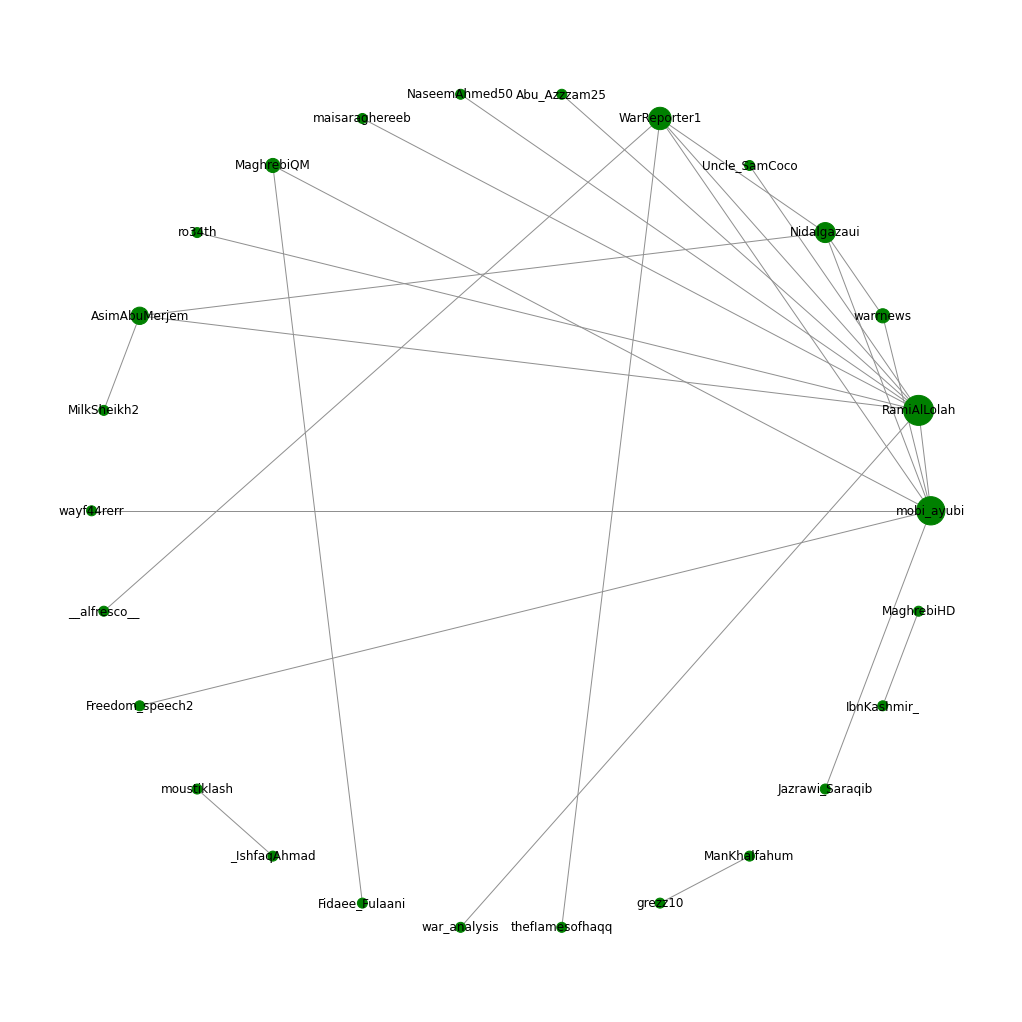

In [14]:
network2 = Mention_net_2.iloc[:,[2,3,4,7]]

network2 = network2.groupby(by=['Mentions','User'],as_index='False')['Weight'].sum().reset_index(name='Weight')
network2= pd.DataFrame(network2).sort_values(by='Weight',ascending=False).reset_index(drop=True)
network2 = network2[network2['Weight']>10]
import networkx as nx
G = nx.Graph()
for i in range(len(network2['User'])):
    G.add_edge(network2['User'][i],network2['Mentions'][i],weight=network2['Weight'][i])
plt.figure(2)
plt.figure(figsize=(14,14))
# d= nx.degree(G)
d = dict(G.degree)
nx.draw_circular(G,node_color='g', edge_color='#909090', node_size=[v*100 for v in d.values()],with_labels=True)
plt.axis('equal')